In [1]:
import sys
from ri_ssim import micro_SSIM
from ri_ssim.CARE_normalization import normalize_CARE, normalize_minmse
from disentangle.core.tiff_reader import load_tiff
import matplotlib.pyplot as plt
import seaborn as sns
from disentangle.analysis.plot_utils import clean_ax
import numpy as np
from collections import defaultdict
from tqdm import tqdm
from ri_ssim.ri_ssim import mse_based_range_invariant_structural_similarity, remove_background
from disentangle.analysis.plot_utils import add_pixel_kde, clean_ax, add_subplot_axes, add_text
import os
from matplotlib import patches





/localscratch/miniforge3/envs/usplit_vdi/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# gt_path = '/group/jug/ashesh/ri_ssim/gt-N2V-2402-31.tif'
# pred_path = '/group/jug/ashesh/ri_ssim/pred-N2V-2402-31.tif'
# noisy_gt_path = '/group/jug/ashesh/data/ventura_gigascience/actin-60x-noise2-lowsnr.tif'

gt_path = '/group/jug/ashesh/ri_ssim/gt-N2V-2402-29.tif'
pred_path = '/group/jug/ashesh/ri_ssim/pred-N2V-2402-29.tif'
noisy_gt_path = '/group/jug/ashesh/data/ventura_gigascience/mito-60x-noise2-lowsnr.tif'

In [3]:
debug_mode = False
gt = load_tiff(gt_path)
pred = load_tiff(pred_path)
gt_lowsnr = load_tiff(noisy_gt_path)

In [11]:
idx = np.random.randint(0, gt.shape[0])
print(idx)
gt_tmp = gt[idx]
pred_tmp = pred[idx]

gt_norm_usual = (gt_tmp - gt_tmp.mean())/gt_tmp.std()
pred_norm_usual = (pred_tmp - pred_tmp.mean())/pred_tmp.std()

gt_norm_CARE = normalize_CARE(gt_tmp.copy())
pred_norm_CARE = normalize_minmse(pred_tmp.copy(), gt_norm_CARE)

pred_norm = remove_background(pred_tmp.copy())
gt_norm = remove_background(gt_tmp.copy())

62


In [12]:
ssim_dict = micro_SSIM(gt_tmp , pred_tmp, ri_factor=1.0, 
                       data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)

ssim_dict_normalized = micro_SSIM(gt_norm_usual , 
                     pred_norm_usual, 
                     ri_factor=1.0,  
                     data_range=gt_norm_usual.max() - gt_norm_usual.min(), return_individual_components=True)

CAREssim_carenorm_dict = micro_SSIM(gt_norm_CARE.copy() , pred_norm_CARE.copy(), 
                                    ri_factor=1.0,
                                    data_range=gt_norm_CARE.max() - gt_norm_CARE.min(), return_individual_components=True)

microssim_dict = micro_SSIM(gt_norm_CARE.copy() , pred_norm.copy(), 
                            ri_factor=None,
                            data_range=gt_norm_CARE.max() - gt_norm_CARE.min(), return_individual_components=True)

In [13]:
# def get_luminance_factors(tmp_dict):
#     alpha = tmp_dict['alpha']
#     ux = tmp_dict['ux']
#     uy = tmp_dict['uy']
#     num_luminance = (2 * alpha * ux * uy)
#     den_luminance = ux**2 + (alpha**2) * uy**2
#     print(num_luminance.mean()/tmp_dict['C1'], den_luminance.mean()/tmp_dict['C1'])

/group/jug/ashesh/ri_ssim/images/bkg_ablation_Idx62_raw_predictions_N2V-2402-29.png


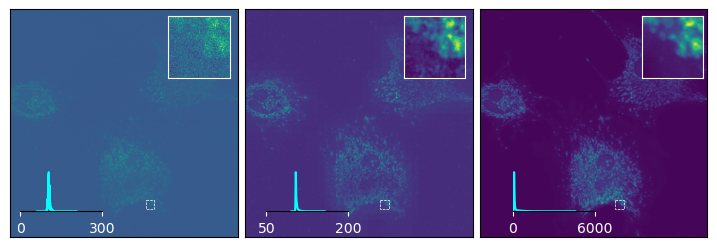

In [15]:
zoomin_sz = 80
save_to_file = True and not debug_mode


def boundary_color(ax_cur, color):
    for spine in ax_cur.spines.values():
        spine.set_edgecolor(color)

def get_zoomin_hw(img):
    hw = None
    hw_std = None
    for _ in range(200):
        h = np.random.randint(0, img.shape[0]-zoomin_sz)
        w = np.random.randint(0, img.shape[1]-zoomin_sz)
        if hw is None:
            hw = [h,w]
            hw_std = img[h:h+80,w:w+80].std()
        else:
            cur_std = img[h:h+80,w:w+80].std()
            if cur_std  > hw_std:
                hw = [h,w]
                hw_std = cur_std
    return hw

_,ax = plt.subplots(figsize=(9,3),ncols=3)
ax[0].imshow(gt_lowsnr[idx])
ax[1].imshow(pred[idx])
ax[2].imshow(gt[idx])

# zoomin rectangles
zoomin_h,zoomin_w = get_zoomin_hw(gt[idx])
rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[0].add_patch(rect)
rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[1].add_patch(rect)

rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[2].add_patch(rect)

# zoomin patches
zoomin_rect = [0.77, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[0], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(gt_lowsnr[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')

zoomin_rect = [0.72, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[1], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(pred[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')

zoomin_rect = [0.68, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[2], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(gt[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')



color_ch = 'cyan'
# color_pred = 'red'
inset_min_labelsize = 10
hist_inset_rect = [0.05, 0.07, 0.4, 0.2]
fac = 1 if save_to_file else 4

add_pixel_kde(ax[0],
                  hist_inset_rect,
                  [gt_lowsnr[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

add_pixel_kde(ax[1],
                  hist_inset_rect,
                  [pred[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

add_pixel_kde(ax[2],
                  hist_inset_rect,
                  [gt[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

clean_ax(ax)
plt.subplots_adjust(wspace=0.03, hspace=0.03)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_Idx{idx}_raw_predictions_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)

/group/jug/ashesh/ri_ssim/images/baseline_comparison_Idx62_N2V-2402-29.png


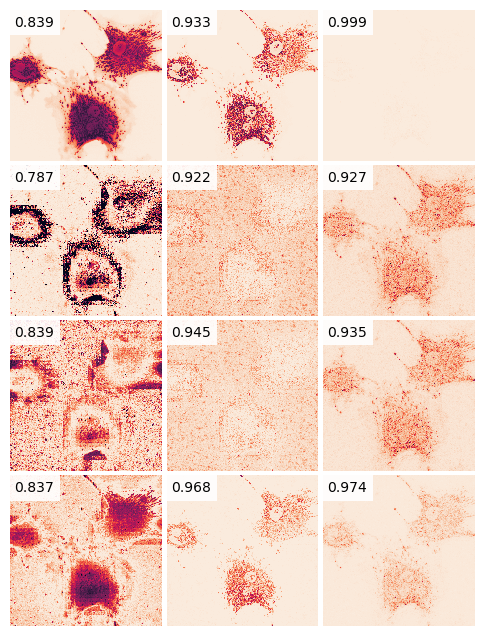

In [16]:
fac = 2 if save_to_file else 4
shape = ssim_dict['luminance'].shape
img_sz = 2
_,ax = plt.subplots(figsize=(img_sz*3,img_sz*4), ncols=3,nrows=4)

# SSIM
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(ssim_dict[key][::fac,::fac],vmin=0,vmax=1,ax=ax[0,i], cbar=False)
    val = f"{ssim_dict[key][::fac,::fac].mean():.3f}"
    add_text(ax[0,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# SSIM NORMALIZED
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(ssim_dict_normalized[key][::fac,::fac],vmin=0,vmax=1,ax=ax[1,i], cbar=False)
    val = f"{ssim_dict_normalized[key][::fac,::fac].mean():.3f}"
    add_text(ax[1,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# CARE-SSIM
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(CAREssim_carenorm_dict[key][::fac,::fac],vmin=0,vmax=1,ax=ax[2,i], cbar=False)
    val = f"{CAREssim_carenorm_dict[key][::fac,::fac].mean():.3f}"
    add_text(ax[2,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# MICRO-SSIM
for i, key in enumerate(['luminance', 'contrast', 'structure']):
    sns.heatmap(microssim_dict[key][::fac,::fac],vmin=0,vmax=1,ax=ax[3,i], cbar=False)
    val = f"{microssim_dict[key][::fac,::fac].mean():.3f}"
    add_text(ax[3,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

clean_ax(ax)
plt.subplots_adjust(wspace=0.03, hspace=0.03)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'baseline_comparison_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)



In [8]:
from skimage.metrics import structural_similarity as ssim
# CAREssim_carenorm_dict = micro_SSIM(gt_norm_CARE , pred_norm_CARE, ri_factor=1.0, gaussian_weights=True, data_range=gt_norm_CARE.max() - gt_norm_CARE.min(), return_individual_components=True)



## Inspecting individual elements: luminance, contrast and structure

In [17]:
idx_list  = list(range(0,100,10))
idx = idx_list[0]
dicts = defaultdict(list)
for idx in tqdm(idx_list):
    for remove_bkg in [True, False]:
        gt_tmp = remove_background(gt[idx]) if remove_bkg else gt[idx]
        gt_tmp_lowsnr = remove_background(gt_lowsnr[idx]) if remove_bkg else gt_lowsnr[idx]
        pred_tmp = remove_background(pred[idx]) if remove_bkg else pred[idx]
        ssim_comp_dict = micro_SSIM(gt_tmp, pred_tmp, ri_factor=None, 
                                    data_range=gt_tmp.max() - gt_tmp.min(), return_individual_components=True)
        dicts[remove_bkg].append(ssim_comp_dict)
        assert np.abs(ssim_comp_dict['SSIM'] - (ssim_comp_dict['luminance'] * ssim_comp_dict['contrast'] * ssim_comp_dict['structure'])).max() < 1e-5

100%|██████████| 10/10 [00:28<00:00,  2.81s/it]


## MSE based scaling SSIM

In [18]:
# dicts_mse = defaultdict(list)
# for idx in tqdm(idx_list):
#     for remove_min in [True, False]:
#         gt_tmp = gt[idx] - gt[idx].min() * remove_min
#         gt_tmp_lowsnr = gt_lowsnr[idx] - gt_lowsnr[idx].min() * remove_min
#         pred_tmp = pred[idx] - pred[idx].min() * remove_min
#         ssim_comp_dict = mse_based_range_invariant_structural_similarity(gt_tmp, 
#                                                                          pred_tmp, 
#                                                                          data_range=gt_tmp.max() - gt_tmp.min(), 
#                                                                          return_individual_components=True)
#         dicts_mse[remove_min].append(ssim_comp_dict)
#         assert np.abs(ssim_comp_dict['SSIM'] - (ssim_comp_dict['luminance'] * ssim_comp_dict['contrast'] * ssim_comp_dict['structure'])).max() < 1e-10

## No scaling.

In [19]:
# dicts_None = defaultdict(list)
# for idx in tqdm(idx_list):
#     for remove_min in [True, False]:
#         gt_tmp = gt[idx] - gt[idx].min() * remove_min
#         gt_tmp_lowsnr = gt_lowsnr[idx] - gt_lowsnr[idx].min() * remove_min
#         pred_tmp = pred[idx] - pred[idx].min() * remove_min
#         ssim_comp_dict = micro_SSIM(gt_tmp, 
#                                                                          pred_tmp, 
#                                                                             ri_factor=1.0,
#                                                                          data_range=gt_tmp.max() - gt_tmp.min(), 
#                                                                          return_individual_components=True)
#         dicts_None[remove_min].append(ssim_comp_dict)
#         assert np.abs(ssim_comp_dict['SSIM'] - (ssim_comp_dict['luminance'] * ssim_comp_dict['contrast'] * ssim_comp_dict['structure'])).max() < 1e-10

In [20]:
# q_arr = [0.5, 0.7]
# for q in q_arr:
#     factor_list = []
#     for i in range(len(gt)):
#         gt_tmp  = gt[i] - np.quantile(gt[i], 0.05)
#         pred_tmp = pred[i] - np.quantile(pred[i], 0.05)
#         factor_list.append(np.quantile(gt_tmp, q)/np.quantile(pred_tmp, q))

#     factor_list = np.array(factor_list)
#     print(q, np.mean(factor_list[idx_list]), np.std(factor_list[idx_list]))

# plt.imshow(gt[0]>np.quantile(tmp_gt, 0.7))

In [21]:
# alpha_ssim = []
# alpha_mse = []
# for i in range(len(idx_list)):
#     alpha_ssim.append(dicts[True][i]['alpha'])
#     alpha_mse.append(dicts_mse[True][i]['alpha'][0,0])

# print('SSIM', np.mean(alpha_ssim), np.std(alpha_ssim))
# print('MSE', np.mean(alpha_mse), np.std(alpha_mse))

In [22]:
# for i in range(len(idx_list)):
#     print(dicts[True][i]['SSIM'].mean(), dicts_mse[True][i]['SSIM'].mean(), dicts_None[True][i]['SSIM'].mean())

/group/jug/ashesh/ri_ssim/images/bkg_ablation_Idx20_raw_predictions_N2V-2402-29.png


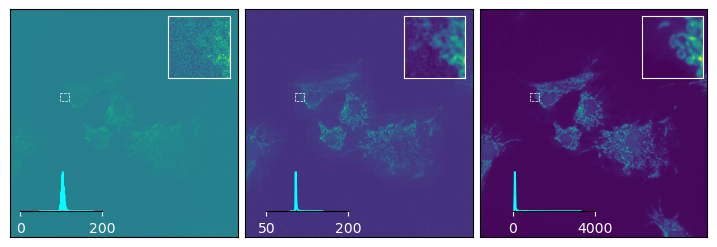

In [23]:

def boundary_color(ax_cur, color):
    for spine in ax_cur.spines.values():
        spine.set_edgecolor(color)

save_to_file = True and not debug_mode
ith_img= 2

idx = idx_list[ith_img]
zoomin_hw = [(700, 750), (1150, 750), (750, 450)][ith_img]
_,ax = plt.subplots(figsize=(9,3),ncols=3)
ax[0].imshow(gt_lowsnr[idx])
ax[1].imshow(pred[idx])
ax[2].imshow(gt[idx])

# zoomin rectangles
zoomin_h,zoomin_w = zoomin_hw
zoomin_sz = 80
rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[0].add_patch(rect)
rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[1].add_patch(rect)

rect = patches.Rectangle((zoomin_w, zoomin_h), zoomin_sz,zoomin_sz, 
                         linewidth=0.5, edgecolor='w', facecolor='none', linestyle='--')
ax[2].add_patch(rect)

# zoomin patches
zoomin_rect = [0.77, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[0], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(gt_lowsnr[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')

zoomin_rect = [0.72, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[1], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(pred[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')

zoomin_rect = [0.68, 0.72, 0.3, 0.3]
zoomin_ax = add_subplot_axes(ax[2], zoomin_rect, facecolor = 'w', min_labelsize = 5)
zoomin_ax.imshow(gt[idx][zoomin_h:zoomin_h+zoomin_sz,zoomin_w:zoomin_w+zoomin_sz])
clean_ax(zoomin_ax)
boundary_color(zoomin_ax, 'white')



color_ch = 'cyan'
# color_pred = 'red'
inset_min_labelsize = 10
hist_inset_rect = [0.05, 0.07, 0.4, 0.2]
fac = 1 if save_to_file else 4
add_pixel_kde(ax[0],
                  hist_inset_rect,
                  [gt_lowsnr[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])




add_pixel_kde(ax[1],
                  hist_inset_rect,
                  [pred[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

add_pixel_kde(ax[2],
                  hist_inset_rect,
                  [gt[idx][::fac,::fac]],
                  inset_min_labelsize,
                  color_list=[color_ch],
                  label_list = [''])

clean_ax(ax)
plt.subplots_adjust(wspace=0.03, hspace=0.03)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_Idx{idx}_raw_predictions_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)

/group/jug/ashesh/ri_ssim/images/bkg_ablation_Idx2_N2V-2402-29.png


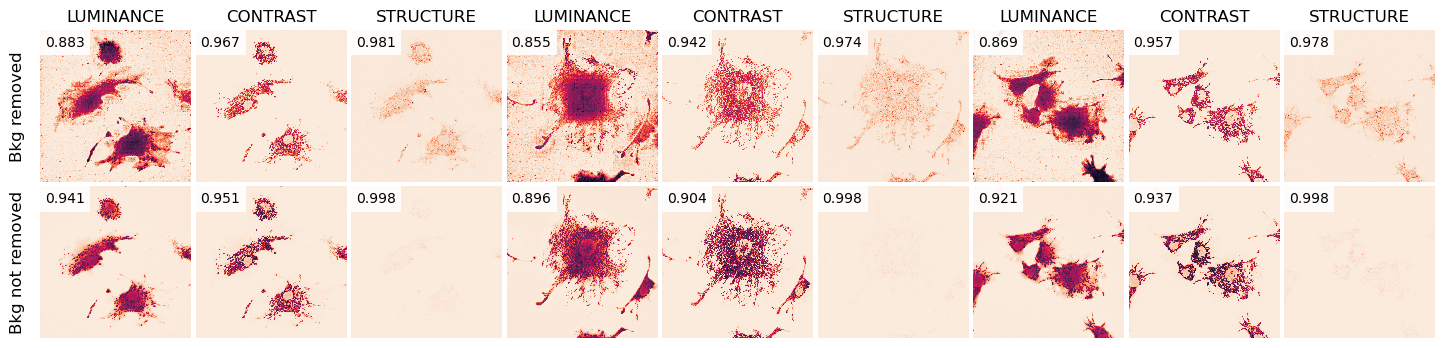

In [24]:
import seaborn as sns
from disentangle.analysis.plot_utils import clean_ax
import os
num_samples = 3

shape = list(dicts[True][0]['luminance'].shape)
fac = 1 if save_to_file else 4
img_sz = 2
_,ax = plt.subplots(figsize=(img_sz*3*num_samples,img_sz*2),ncols=3*num_samples,nrows=2)

for idx in range(num_samples):
# For True
    for i, key in enumerate(['luminance', 'contrast', 'structure']):
        sns.heatmap(dicts[True][idx][key][::fac,::fac],vmin=0,vmax=1,ax=ax[0,3*idx + i], cbar=False)
        val = f"{dicts[True][idx][key][::fac,::fac].mean():.3f}"
        add_text(ax[0,3*idx + i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

    # For False
    for i, key in enumerate(['luminance', 'contrast', 'structure']):
        sns.heatmap(dicts[False][idx][key][::fac,::fac],vmin=0,vmax=1,ax=ax[1,3*idx + i], cbar=False)
        val = f"{dicts[False][idx][key][::fac,::fac].mean():.3f}"
        add_text(ax[1,3*idx + i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

    ax[0,idx*3 + 0].set_title('Luminance'.upper())
    ax[0,idx*3 + 1].set_title('Contrast'.upper())
    ax[0,idx*3 + 2].set_title('Structure'.upper())


clean_ax(ax)


alpha_true = round(dicts[True][idx]['alpha'],2)
ax[0,0].set_ylabel('Bkg removed', fontsize=12)

alpha_false = round(dicts[False][idx]['alpha'],2)
ax[1,0].set_ylabel('Bkg not removed', fontsize=12)

plt.subplots_adjust(wspace=0.03, hspace=0.03)
# plt.tight_layout()
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    # plt.tight_layout()
    plt.savefig(fpath, dpi=200)


In [17]:
# import seaborn as sns
# from disentangle.analysis.plot_utils import clean_ax
# import os
# idx = idx_list[0]

# shape = list(dicts[True][idx]['luminance'].shape)
# fac = 1 if save_to_file else 4
# img_sz = 2
# _,ax = plt.subplots(figsize=(img_sz*3,img_sz*2),ncols=3,nrows=2)

# # For True
# for i, key in enumerate(['luminance', 'contrast', 'structure']):
#     sns.heatmap(dicts[True][idx][key][::fac,::fac],vmin=0,vmax=1,ax=ax[0,i], cbar=False)
#     val = f"{dicts[True][idx][key][::fac,::fac].mean():.3f}"
#     add_text(ax[0,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')

# # For False
# for i, key in enumerate(['luminance', 'contrast', 'structure']):
#     sns.heatmap(dicts[False][idx][key][::fac,::fac],vmin=0,vmax=1,ax=ax[1,i], cbar=False)
#     val = f"{dicts[False][idx][key][::fac,::fac].mean():.3f}"
#     add_text(ax[1,i], val, (shape[0]//fac, shape[1]//fac), edgecolor='none')


# clean_ax(ax)
# ax[0,0].set_title('Luminance'.upper())
# ax[0,1].set_title('Contrast'.upper())
# ax[0,2].set_title('Structure'.upper())

# alpha_true = round(dicts[True][idx]['alpha'],2)
# ax[0,0].set_ylabel('Bkg removed,  ' + f'$\\alpha=${alpha_true}', fontsize=12)

# alpha_false = round(dicts[False][idx]['alpha'],2)
# ax[1,0].set_ylabel('Bkg not removed,  ' + f'$\\alpha=${alpha_false}', fontsize=12)

# plt.subplots_adjust(wspace=0, hspace=0)
# plt.tight_layout()
# if save_to_file:
#     postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
#     fname = f'bkg_ablation_Idx{idx}_{postfix}'
#     fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
#     print(fpath)
#     plt.tight_layout()
#     plt.savefig(fpath, dpi=200)


### Inspecting background on differently intense pixels

In [18]:
# q_list = [0.01, 0.1, 0.5, 0.9,0.95]
# imgsz = 2
# _,ax = plt.subplots(figsize=(imgsz * len(q_list), imgsz), ncols=len(q_list))
# padx = pady = None
# for ax_idx, q_ in enumerate(q_list):
#     q_val = np.quantile(gt[idx], q_)
#     mask = gt[idx] > q_val
#     ax[ax_idx].imshow(mask)
#     if padx is None:
#         padx, pady = (np.array(mask.shape) - np.array(dicts[True][0]['SSIM'].shape) )//2

#     mask = mask[pady:-pady,padx:-padx]
    
#     ssim_true = 0
#     ssim_false = 0
#     for idx in range(len(dicts[True])):
#         ssim_true += dicts[True][idx]['SSIM'][mask].mean()
#         ssim_false += dicts[False][idx]['SSIM'][mask].mean()
    
#     ssim_true /= len(dicts[True])
#     ssim_false /= len(dicts[False])
#     print(q_,q_val, ssim_true, ssim_false)

# clean_ax(ax)

## Background levels 

In [19]:
# from ri_ssim.ri_ssim import _ssim_from_params, structural_similarity_dict, _get_ri_factor
# q_min = 0.1
# idx = np.random.choice(len(gt))
# gt_cur = gt[idx] - np.quantile(gt[idx], q_min)
# pred_cur = pred[idx] - np.quantile(pred[idx], q_min)
# gt_cur[gt_cur < 0] = 0
# pred_cur[pred_cur < 0] = 0

# ssim_dict = structural_similarity_dict(
#     gt_cur,
#     pred_cur,
#     data_range=gt_cur.max() - gt_cur.min())

# ri_factor = _get_ri_factor(ssim_dict)
# ux, uy, vx, vy, vxy, C1, C2 = (
#     ssim_dict["ux"],
#     ssim_dict["uy"],
#     ssim_dict["vx"],
#     ssim_dict["vy"],
#     ssim_dict["vxy"],
#     ssim_dict["C1"],
#     ssim_dict["C2"],
# )
# raw_dict = _ssim_from_params(
#     ri_factor,
#     ux,
#     uy,
#     vx,
#     vy,
#     vxy,
#     C1,
#     C2,
#     return_individual_components=True,
# )

# q_vals = np.quantile(gt_tmp, [0,0.01,0.05,0.1,0.9, 0.95, 0.99])
# for qv in q_vals:
#     mask = gt_cur > np.quantile(gt_cur, qv)


# Manual varying of alpha: inspecting its uniqueness

In [25]:
from ri_ssim.ri_ssim import _ssim_from_params, structural_similarity_dict
from tqdm import tqdm
import numpy as np
from collections import defaultdict
save_to_file = True and not debug_mode

ssim_components = defaultdict(list)
idx_list = []
alpha_list = np.concatenate([np.arange(0,300,1)])
num_idx = 30
for idx in np.random.choice(len(gt), size=num_idx, replace=False):
    idx_list.append(idx)
    gt_cur = remove_background(gt[idx])
    pred_cur = remove_background(pred[idx])
    random_pred = np.random.rand(*gt_cur.shape)
    random_pred = random_pred - random_pred.min()


    ssim_dict = structural_similarity_dict(
        gt_cur,
        pred_cur,
        data_range=gt_cur.max() - gt_cur.min())

    ux, uy, vx, vy, vxy, C1, C2 = (
        ssim_dict["ux"],
        ssim_dict["uy"],
        ssim_dict["vx"],
        ssim_dict["vy"],
        ssim_dict["vxy"],
        ssim_dict["C1"],
        ssim_dict["C2"],
    )

    ssim_arr = []
    # luminance_arr = []
    # contrast_arr = []
    # structure_arr = []
    for factor in tqdm(alpha_list):
        ssim_dict = _ssim_from_params(factor, ux, uy, vx, vy, vxy, C1, C2, return_individual_components=True)
        ssim_arr.append(ssim_dict['SSIM'].mean())
        # luminance_arr.append(ssim_dict['luminance'].mean())
        # contrast_arr.append(ssim_dict['contrast'].mean())
        # structure_arr.append(ssim_dict['structure'].mean())
    
    ssim_components['ssim'].append(ssim_arr)
    # ssim_components['luminance'].append(luminance_arr)
    # ssim_components['contrast'].append(contrast_arr)
    # ssim_components['structure'].append(structure_arr)
    

100%|██████████| 300/300 [00:08<00:00, 36.83it/s]


/group/jug/ashesh/ri_ssim/images/ssim_uniqueness_Idx96_N2V-2402-29.png


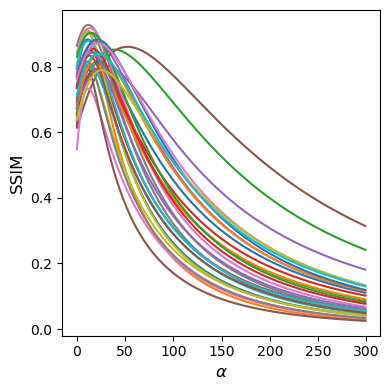

In [27]:
import pandas as pd
_,ax = plt.subplots(figsize=(4,4))
pd.DataFrame(np.stack(ssim_components['ssim']).T, index=alpha_list).plot(legend=False, ax=ax)
ax.set_xlabel('$\\alpha$', fontsize=12)
ax.set_ylabel('SSIM', fontsize=12)
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'ssim_uniqueness_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=200)


# Manual varying of alpha: inspecting the components

In [28]:
from ri_ssim.ri_ssim import _ssim_from_params, structural_similarity_dict
from tqdm import tqdm
import numpy as np
from collections import defaultdict

gt_cur = remove_background(gt[idx])
pred_cur = remove_background(pred[idx])
random_pred = np.random.rand(*gt_cur.shape)
random_pred = random_pred - random_pred.min()

pred_list = [pred_cur, pred_cur[::-1], pred_cur[:,::-1], pred_cur[::-1,::-1], random_pred]
# alpha_list = np.concatenate([np.arange(0.03,20,0.03),np.arange(20,100,0.1), np.arange(100,300,1), np.arange(300,1000,3)])
alpha_list = np.concatenate([np.arange(0.03,100,0.4)])
ssim_components = defaultdict(list)

for pred_tmp in pred_list:
    ssim_dict = structural_similarity_dict(
        gt_cur,
        pred_tmp,
        data_range=gt_cur.max() - gt_cur.min())

    ux, uy, vx, vy, vxy, C1, C2 = (
        ssim_dict["ux"],
        ssim_dict["uy"],
        ssim_dict["vx"],
        ssim_dict["vy"],
        ssim_dict["vxy"],
        ssim_dict["C1"],
        ssim_dict["C2"],
    )

    ssim_arr = []
    luminance_arr = []
    contrast_arr = []
    structure_arr = []
    for factor in tqdm(alpha_list):
        ssim_dict = _ssim_from_params(factor, ux, uy, vx, vy, vxy, C1, C2, return_individual_components=True)
        ssim_arr.append(ssim_dict['SSIM'].mean())
        luminance_arr.append(ssim_dict['luminance'].mean())
        contrast_arr.append(ssim_dict['contrast'].mean())
        structure_arr.append(ssim_dict['structure'].mean())
    
    ssim_components['ssim'].append(ssim_arr)
    ssim_components['luminance'].append(luminance_arr)
    ssim_components['contrast'].append(contrast_arr)
    ssim_components['structure'].append(structure_arr)
    

100%|██████████| 250/250 [00:06<00:00, 35.74it/s]


/group/jug/ashesh/ri_ssim/images/ssim_components_Idx96_N2V-2402-29.png


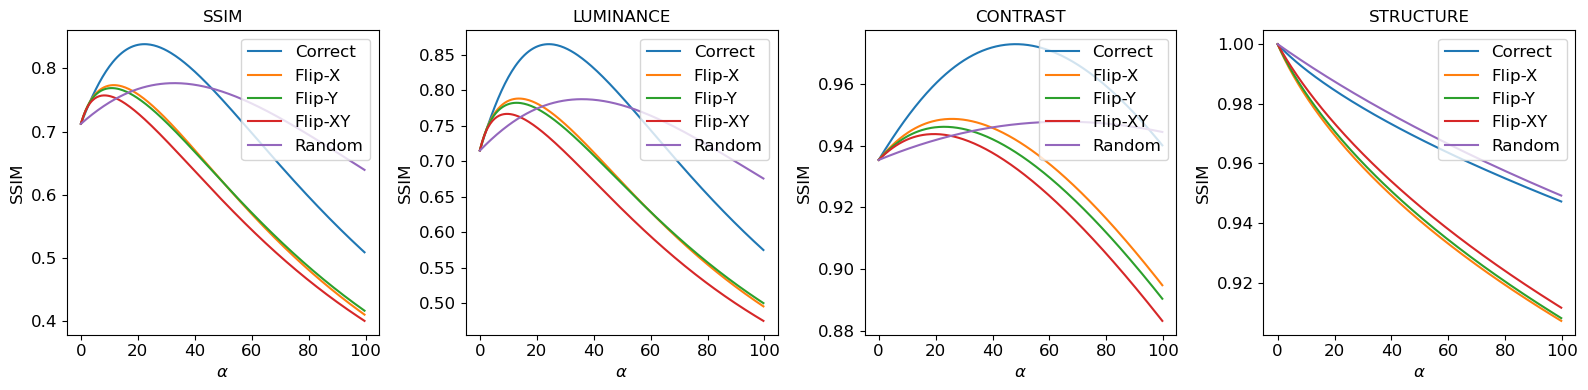

In [29]:
import pandas as pd
import os
save_to_file = True and not debug_mode

_,ax = plt.subplots(figsize=(16,4),ncols=4)
for i, key in enumerate(['ssim','luminance','contrast','structure']):
    df = pd.DataFrame(np.stack(ssim_components[key]).T, columns = ['Correct', 'Flip-X', 'Flip-Y', 'Flip-XY', 'Random'], index =alpha_list)
    df.plot(fontsize=12, ax=ax[i]).legend(loc='upper right', fontsize=12)
    ax[i].set_title(key.upper(), fontsize=12)

for i in range(4):
    ax[i].set_xlabel('$\\alpha$', fontsize=12)
    ax[i].set_ylabel('SSIM', fontsize=12)

if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'ssim_components_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=200)

In [24]:
# df = pd.DataFrame(np.stack(ssim_components['ssim']).T, columns = ['Correct', 'Flip-X', 'Flip-Y', 'Flip-XY', 'Random'], index =alpha_list)
# df

## Experiment on how the offset plays a role in performance

In [30]:
import numpy as np
from tqdm import tqdm
idx = np.random.randint(0,len(gt))
enable_ri = False
gt_cur = remove_background(gt[idx])
pred_cur = remove_background(pred[idx])
ssim_arr = []
lum_arr = []
con_arr = []
str_arr = []
offset_arr = list(range(-100,300,10))
for offset in tqdm(offset_arr):
    ssim_dict = micro_SSIM(gt_cur + offset , 
                           pred_cur + offset, 
                           ri_factor=None if enable_ri else 1.0, data_range=gt_cur.max() - gt_cur.min(), return_individual_components=True)
    ssim_arr.append(ssim_dict['SSIM'].mean())
    lum_arr.append(ssim_dict['luminance'].mean())
    con_arr.append(ssim_dict['contrast'].mean())
    str_arr.append(ssim_dict['structure'].mean())

100%|██████████| 40/40 [00:21<00:00,  1.89it/s]


/group/jug/ashesh/ri_ssim/images/bkg_ablation_plot_Idx84_N2V-2402-29.png


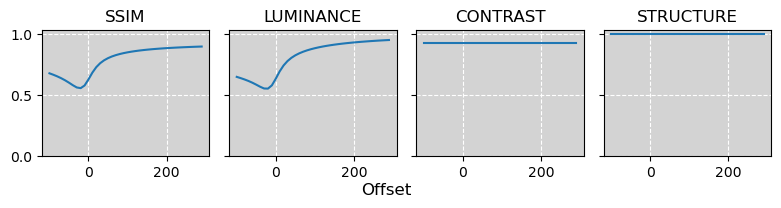

In [32]:
import matplotlib.pyplot as plt
import os
save_to_file = True and not debug_mode

fig,ax = plt.subplots(figsize=(8,2),ncols=4)
ax[0].plot(offset_arr,ssim_arr)
ax[1].plot(offset_arr,lum_arr)
ax[2].plot(offset_arr,con_arr)
ax[3].plot(offset_arr,str_arr)
# ax[3].set_yscale('log')
for ax_ in ax:
    # ax_.set_ylim([0.0,1.1])
    ax_.set_ylim([0,1.03])
    ax_.grid(visible=True, color='w', linestyle='--')
    ax_.set_facecolor('lightgrey')

for ax_ in ax[1:]:
    ax_.set_yticklabels([])


plt.subplots_adjust(wspace=0.1, hspace=0.1)
ax[0].set_title('SSIM')
ax[1].set_title('LUMINANCE')
ax[2].set_title('CONTRAST')
ax[3].set_title('STRUCTURE')

fig.text(0.5, 0.0, 'Offset', ha='center', fontsize=12)

if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'bkg_ablation_plot_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=200)


/group/jug/ashesh/ri_ssim/images/luminance_synthetic_plot_Idx84_N2V-2402-29.png


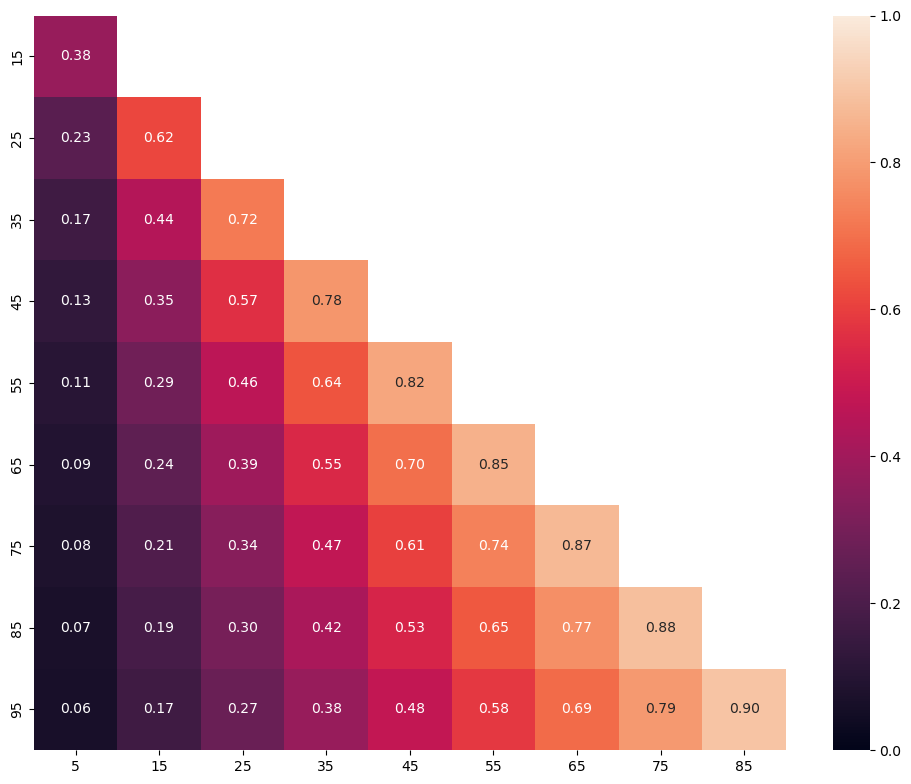

In [33]:
def compute(numerator_factor, denominator_factor):
    return (1 + numerator_factor)/(1 + denominator_factor)
    
num_factor = np.arange(5, 100, 10)
den_factor = np.arange(5, 100, 10)
num_cor, den_cor = np.meshgrid(num_factor, den_factor)
lum = np.array([compute(num_cor[i], den_cor[i]) for i in range(num_cor.shape[0])])
lum = lum.reshape(len(num_factor),len(num_factor))

# we skip the last numerator and first denominator
lum = lum[1:,:-1]
num_cor = num_cor[1:,:-1]
den_cor = den_cor[1:,:-1]
num_factor = num_factor[:-1]
den_factor = den_factor[1:]
mask = den_cor <= num_cor

import pandas as pd
_, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pd.DataFrame(lum,index=den_factor,columns=num_factor), annot=True, mask=mask,vmin=0,vmax=1, fmt=".2f")
sns.set_theme(style='white')
if save_to_file:
    postfix= os.path.basename(gt_path).replace('gt-','').replace('.tif','.png')
    fname = f'luminance_synthetic_plot_Idx{idx}_{postfix}'
    fpath = os.path.join('/group/jug/ashesh/ri_ssim/images', fname)
    print(fpath)
    plt.tight_layout()
    plt.savefig(fpath, dpi=200)
